# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [6]:
!pip install tqdm pandasql

In [7]:
from matplotlib.colors import ListedColormap
from tqdm import tqdm

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandasql as pdsql
import seaborn as sns
import pandas as pd
import numpy as np
import math
import json

# read in the json files
portfolio = pd.read_json('./data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('./data/profile.json', orient='records', lines=True)
transcript = pd.read_json('./data/transcript.json', orient='records', lines=True)

----

## Questions

For completing this project, I am going to answer several questions according to the given datasets. The questions below are formed in order to know better about customers behaviour and interaction with the offers.

If we can map the behaviour and find some specific patterns about customers behaviour in using offers, hopefully the marketing team will target the right customers to be able to increase the sales.

Here are a few questions we are going to answer in this notebook.

<b>1. How much we loss because of the "unecessary offer"?</b> <br>
<b>2. What kind of customers that often completed the offer without viewing it?</b> <br>
<b>3. How is the income differentiate between customers type?</b>

Before we answer the questions, we are going to do the data wrangling process first to clean the data so it can be analyzed.

---

## Data Wrangling

### Portfolio

In [8]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


For the portfolio dataframe, we want to convert the channels column into one-hot-encoding type of column so we can analyze it better.

In [9]:
###
## PORTFOLIO PREPROCESSING
#

values = []

for index, row in portfolio.iterrows():
    
    new_value = [0,0,0,0]
    
    for item in row['channels']:
        if item == 'web':
            new_value[0] = 1
        elif item == 'email':
            new_value[1] = 1
        elif item == 'mobile':
            new_value[2] = 1
        elif item == 'social':
            new_value[3] = 1
            
    values.append(new_value)
    
portfolio = pd.concat([portfolio, pd.DataFrame(values, columns=['web', 'email', 'mobile', 'social'])], axis=1)
portfolio.drop(columns=['channels'], inplace=True)

portfolio

,difficulty,duration,id,offer_type,reward,web,email,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


### Transcript

In [10]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


For the transcript dataframe, we want to extract the values from column `value`. There are three values in that column which are `amount`, `offer_id`, and `reward`. This preprocessing will extract those values and convert it into columns.

In [11]:
###
## TRANSCRIPT PREPROCESSING
#

# Convert the dictionary value into columns and concatenate with the current dataframe
value = pd.io.json.json_normalize(transcript['value'])
transcript = pd.concat([transcript, value], axis=1).drop(columns=['value'])

# Merge the offer_id column and offer id collumn so that it only has one column
transcript['offer_id'] = np.where(pd.isnull(transcript['offer_id']), transcript['offer id'], transcript['offer_id'])
transcript.drop(columns=['offer id'], inplace=True)

# Fill the null values with 0
transcript.fillna(0, inplace=True)

transcript.head()

,event,person,time,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,0.0,2906b810c7d4411798c6938adc9daaa5,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0


### Profile

In [12]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


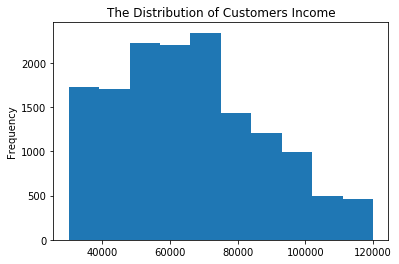

In [13]:
profile['income'].plot.hist()
plt.title('The Distribution of Customers Income')
plt.show()

The distribution of income, we can see that it is positively skewed.

In [14]:
profile['age'].value_counts().head()

118    2175
58      408
53      372
51      363
54      359
Name: age, dtype: int64

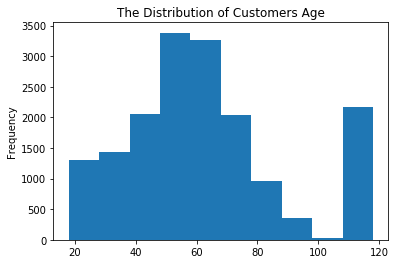

In [15]:
profile['age'].plot.hist()
plt.title('The Distribution of Customers Age')
plt.show()

**The high number of values of age 118*

For this dataframe, there are quite high number of null values in the gender and income columns. If we see the data, we can also see that all of the rows with null values in gender and income also have the age 118 (and for this case, we assume the customers with the age > 100 are outliers, so we are gonna treat them the same).

To handle this case, I am going to fill the null values in each column (and rows with age > 100) with the median and mode of that columns (mode for gender, median for age and income) of the specific day (from `became_member_on` column).

So here is the plan to fix the data.

- For the `gender` column, fill the null values with mode of that day (`became_member_on` column)
- For the `income` column, fill the null values with median of that day (`became_member_on` column)
- For the `age` column, change all of the value of 118 to median of that day (`became_member_on` column)

In [16]:
###
## PROFILE PREPROCESSING
#


# Convert the became_member_on into datetime type
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

# Create a new column with the value of the difference days between the column became_member_on and the max days
profile['difference_days'] = (profile['became_member_on'].max() - profile['became_member_on']).dt.days

## Find the median and mode
#

# Find median of age
median_age_per_day = profile.groupby('became_member_on', as_index=False)['age'].median()

# Find median of income
median_income_per_day = profile.groupby('became_member_on', as_index=False)['income'].median()

# Find mode of gender
mode_gender_per_day = profile.groupby('became_member_on')['gender'].agg(lambda x: pd.Series.mode(x))
mode_gender_per_day_value = [i if isinstance(i, str) else 'M' for i in mode_gender_per_day]


## Fill the value based on the condition
#

# Convert age 118 to the median of that day
age_reference = dict(zip(median_age_per_day['became_member_on'], median_age_per_day['age']))
profile['age'] = profile['age'].replace({118: None, 101: None}).fillna(profile['became_member_on'].map(age_reference))
profile.loc[profile['age'] > 100, 'age'] = profile['age'].median()

# Fill the null values in gender column with the mode
gender_reference = dict(zip(mode_gender_per_day.index,mode_gender_per_day_value))
profile['gender'] = profile['gender'].fillna(profile['became_member_on'].map(gender_reference))

# Fill the null values in income column with the median
income_reference = dict(zip(median_income_per_day['became_member_on'], median_income_per_day['income']))
profile['income'] = profile['income'].fillna(profile['became_member_on'].map(income_reference))
profile['income'].fillna(profile['income'].median(), inplace=True)

# Round down the age column
profile['age'] = profile['age'].astype(int)

In [17]:
profile.head()

,age,became_member_on,gender,id,income,difference_days
0,55,2017-02-12,M,68be06ca386d4c31939f3a4f0e3dd783,56000.0,529
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,376
2,65,2018-07-12,M,38fe809add3b4fcf9315a9694bb96ff5,64000.0,14
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443
4,73,2017-08-04,M,a03223e636434f42ac4c3df47e8bac43,65000.0,356


### Combining the data

In order to make it easier to analyze, we are going to compile the users activity history in one dataframe (this is gonna take a while, about 9-10 minutes).

Each row in the dataframe represents each offer that was being sent to each user. So we can track each offer performance for each user or for specific segment of user.

The `compiled_data` dataframe will have these columns:
- `person`: each customer unique id
- `offer_id`:offer id
- `viewed`: did customer see the offer? `0` -> no and `1` -> yes
- `completed`: did customer completed the offer? `0` -> no and `1` -> yes
- `view_information`: shows whether the customer saw the informational offer or not (before completed the offer)
- `time_completed`: how long the customer need for completing the offer (in hour, starts after they viewed the offer)
- `reward`: reward of that specific offer
- `offer_type`: type of offer

Then we are going to merge the `compiled_data` with `profile` and `portfolio` dataframe.

In [18]:
# Reference
offer_reference = {}

for i,j in zip(portfolio['id'], portfolio['offer_type']):
    offer_reference[i] = j
    

offer_duration_reference = {}

for i,j in zip(portfolio['id'], portfolio['duration']):
    offer_duration_reference[i] = j*24
    
    
full_data = []

# Iterate through each person
for person in tqdm(list(transcript['person'].unique())):
    
    not_completed = {}
    received = []
    active = []
    total_data = {}
    information = []

    for index, row in transcript[transcript['person'] == person].iterrows():

        if row['event'] == 'offer received':

            # Everytime there is an offer received, do this
            received.append(row['offer_id'])
            key = row['offer_id'] + '-' + str(received.count(row['offer_id']))
            not_completed[key] = row['time']
            total_data[key] = [row['person'], row['offer_id'], 0, 0, 0, 0] 


        if row['event'] == 'offer viewed':

            # If the customers have seen the informational offer
            if offer_reference[row['offer_id']] == 'informational':
                information.append(row['offer_id'])

            # Everytime the offer is viewed, do this
            active = list(filter(lambda x: x.split('-')[0] == row['offer_id'], list(not_completed.keys())))

            # If there is only one offer_id active
            if len(active) == 1:

                # Only change the value if the offer is not completed yet
                if active[0] in not_completed:                    
                    total_data[active[0]][2] = 1

            # If there are more than one offer_id active
            else:
                for offer_id in active:
                    if (row['time'] - not_completed[offer_id]) < offer_duration_reference[row['offer_id']]:
                        if total_data[offer_id][2] == 1:
                            continue
                        total_data[offer_id][2] = 1
                        break


        if row['event'] == 'offer completed':

            # If the users completed the offer and have seen the informational offer
            info = False
            if len(information) > 0:
                info = True

            # Everytime the offer is completed, do this
            active = list(filter(lambda x: x.split('-')[0] == row['offer_id'], list(not_completed.keys())))

            # If there is only one offer_id active
            if len(active) == 1:
                total_data[active[0]][3] = 1
                total_data[active[0]][5] = row['time'] - not_completed[active[0]]
                not_completed.pop(active[0])

                if info:
                    total_data[active[0]][4] = 1

                continue

            # If there is more that one offer_id active
            else:
                for offer_id in active:
                    if (row['time'] - not_completed[offer_id]) < offer_duration_reference[row['offer_id']]:
                        total_data[offer_id][3] = 1
                        total_data[offer_id][5] = row['time'] - not_completed[offer_id]
                        not_completed.pop(offer_id)

                        if info:
                            total_data[offer_id][4] = 1

                        break

    for index, value in total_data.items():
        full_data += [value]

100%|██████████| 17000/17000 [09:35<00:00, 29.53it/s]


In [19]:
# Create a dataframe based on the compile result
compiled_data = pd.DataFrame(full_data, columns=['person', 'offer_id', 'viewed', 'completed', 'view_information', 'time_completed'])

compiled_data.head()

,person,offer_id,viewed,completed,view_information,time_completed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,132
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,1,0,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,102
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,0,1,1,6
4,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,0


In [20]:
# Merge with the portfolio and profile dataframe
compiled_data_merged = compiled_data.merge(portfolio, left_on='offer_id', right_on='id').drop(columns=['id'])
complete_data = compiled_data_merged.merge(profile, left_on='person', right_on='id').drop(columns=['id'])

complete_data.head()

,person,offer_id,viewed,completed,view_information,time_completed,difficulty,duration,offer_type,reward,web,email,mobile,social,age,became_member_on,gender,income,difference_days
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,132,5,7,bogo,5,1,1,1,0,75,2017-05-09,F,100000.0,443
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,1,0,0,0,0,3,informational,0,0,1,1,1,75,2017-05-09,F,100000.0,443
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,102,10,7,bogo,10,0,1,1,1,75,2017-05-09,F,100000.0,443
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,0,1,1,6,5,5,bogo,5,1,1,1,1,75,2017-05-09,F,100000.0,443
4,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,114,5,7,bogo,5,1,1,1,0,68,2018-04-26,M,70000.0,91


---

## Data Exploration

In this section, we are going to explore the data to answer our questions in the previous section.

### 1. How much we actually loss

We already have the compiled dataframe, where each row represents each offer sent to each user. Column `viewed` means whether the offer has been viewed by the customers or not.

Now let's calculate how much we actually gave the `reward` to those customers who didn't actually view the offer.

In [21]:
complete_data[(complete_data['viewed'] == 0) & (complete_data['completed'] == 1)]['reward'].sum()

49032

Based on the data in the experiment, **we actually "lost" USD 49,032 in revenue**.

If we take a look at column `time` in dataframe `transcript`, we can get maximum value of 714, which means the maximum experiment time is 714 hours = 30 days, so we can assume that the experiment is running for 30 days or a month. 

With that being said, on average **we have a potential loss of 49,032 x 12 = USD 588,384 of revenue in a year.**

Let's take a look deeper into the case and breakdown it.

In [22]:
query = """
        SELECT
            complete.offer_id,
            complete.offer_type,
            total_completed,
            total_completed_without_view,
            ROUND(((1.0*total_completed_without_view) / (1.0*total_completed))*100, 2) as total_completed_without_view_ratio,
            100 - ROUND(((1.0*total_completed_without_view) / (1.0*total_completed))*100, 2) as total_completed_with_view_ratio,
            `loss ($)`
        FROM
            (SELECT
                offer_id,
                offer_type,
                COUNT(*) AS total_completed
            FROM
                complete_data
            WHERE
                completed = 1
            GROUP BY
                offer_id) complete
                
        JOIN
            (SELECT
                offer_id,
                offer_type,
                COUNT(*) AS total_completed_without_view,
                SUM(reward) AS `loss ($)`
            FROM
                complete_data
            WHERE
                viewed = 0
                AND completed = 1
            GROUP BY
                offer_id) complete_not_view ON complete.offer_id = complete_not_view.offer_id
                
        ORDER BY
            total_completed_without_view_ratio DESC
        """

completed_without_view = pdsql.sqldf(query)

completed_without_view

,offer_id,offer_type,total_completed,total_completed_without_view,total_completed_without_view_ratio,total_completed_with_view_ratio,loss ($)
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,3418,2086,61.03,38.97,10430
1,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,4351,2231,51.28,48.72,11155
2,2906b810c7d4411798c6938adc9daaa5,discount,4013,1890,47.10,52.90,3780
3,ae264e3637204a6fb9bb56bc8210ddfd,bogo,3687,1068,28.97,71.03,10680
4,f19421c1d4aa40978ebb69ca19b0e20d,bogo,4287,755,17.61,82.39,3775
5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,3323,562,16.91,83.09,5620
6,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,5148,762,14.80,85.20,2286
7,fafdcd668e3743c1bb461111dcafc2a4,discount,5315,653,12.29,87.71,1306


In [23]:
table = completed_without_view.groupby('offer_type', as_index=False) \
                              .agg({'loss ($)': ['sum'],
                                    'total_completed_without_view': ['sum']})

table.columns = [' '.join(col).strip() for col in table.columns.values]

table

,offer_type,loss ($) sum,total_completed_without_view sum
0,bogo,31230,4616
1,discount,17802,5391


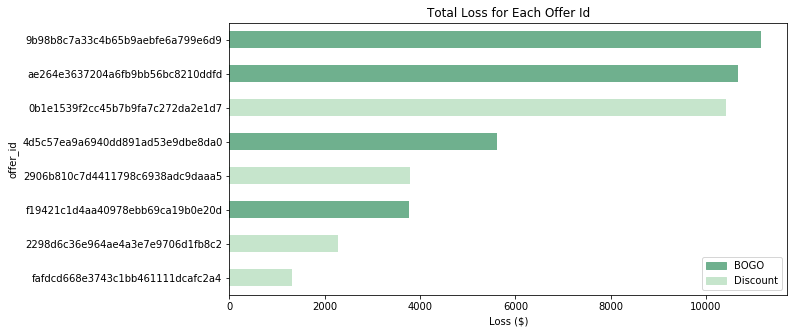

In [24]:
viz = completed_without_view[['offer_id', 'loss ($)', 'offer_type']].set_index('offer_id') \
                                                                    .sort_values('loss ($)')

colors = tuple(np.where(viz['offer_type'] == 'discount', '#C6E5CC', '#6fb08e'))

viz['loss ($)'].plot(kind='barh',
                     color=colors,
                     figsize=(10,5))

discount = mpatches.Patch(color='#C6E5CC', label='Discount')
bogo = mpatches.Patch(color='#6fb08e', label='BOGO')

plt.legend(handles=[bogo, discount])
plt.title('Total Loss for Each Offer Id')
plt.xlabel('Loss ($)')
plt.show()

**Discount**<br>
Total: 5,391<br>
Loss: USD 17,802

**Buy One Get One (BOGO)**<br>
Total: 4,616<br>
Loss: USD 31,230

There are 8 offers, and **most of the loss are from BOGO offer**.

Eventhough the total completed offer of discount is higher than BOGO, in fact **the total loss of BOGO offer is almost double the total loss of discount.**

### 2. Customers that complete the offer without viewing it before

Let's take a look into gender specifically. Is there any difference in behaviour between Male, Female, and Others?

In [25]:
query = """
        SELECT
            complete.offer_type,
            complete.gender,
            complete.complete_without_view,
            complete_view.complete_with_view,
            (complete.complete_without_view + complete_view.complete_with_view) total_complete
            
        FROM
            (SELECT
                offer_type,
                gender,
                COUNT(*) complete_without_view
            FROM
                complete_data
            WHERE
                viewed = 0
                AND completed = 1
            GROUP BY
                offer_type, gender) complete
        
        JOIN
            (SELECT
                offer_type,
                gender,
                COUNT(*) complete_with_view
            FROM
                complete_data
            WHERE
                viewed = 1
                AND completed = 1
            GROUP BY
                offer_type, gender) complete_view ON complete.offer_type = complete_view.offer_type
                                                     AND complete.gender = complete_view.gender
        """

user_demographic_summary = pdsql.sqldf(query)

user_demographic_summary['complete_without_view_ratio'] = round((user_demographic_summary['complete_without_view'] / user_demographic_summary['total_complete']) * 100, 2)
user_demographic_summary['complete_with_view_ratio'] = round((user_demographic_summary['complete_with_view'] / user_demographic_summary['total_complete']) * 100, 2)

user_demographic_summary['gender'] = user_demographic_summary['gender'].map({'F': 'Female', 'M': 'Male', 'O': 'Others'})

user_demographic_summary

,offer_type,gender,complete_without_view,complete_with_view,total_complete,complete_without_view_ratio,complete_with_view_ratio
0,bogo,Female,2267,5366,7633,29.70,70.30
1,bogo,Male,2296,5475,7771,29.55,70.45
2,bogo,Others,53,191,244,21.72,78.28
3,discount,Female,2743,5471,8214,33.39,66.61
4,discount,Male,2592,6832,9424,27.50,72.50
5,discount,Others,56,200,256,21.88,78.12


ValueError: ch:2.5,-.2,dark=.6 is not a valid palette name

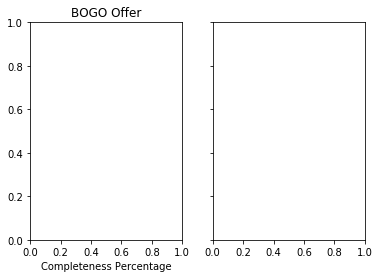

In [26]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)

ax.title.set_text('BOGO Offer')
ax.set_xlabel('Completeness Percentage')
user_demographic_summary[user_demographic_summary['offer_type'] == 'bogo'] \
                        [['gender', 'complete_without_view_ratio', 'complete_with_view_ratio']] \
                        .set_index('gender') \
                        .plot(kind='barh',
                              legend=False,
                              stacked=True,
                              colormap=ListedColormap(sns.color_palette("ch:2.5,-.2,dark=.6")),
                              figsize=(13,5),
                              ax=ax)


ax2.title.set_text('Discount Offer')
ax2.set_xlabel('Completeness Percentage')
user_demographic_summary[user_demographic_summary['offer_type'] == 'discount'] \
                        [['gender', 'complete_without_view_ratio', 'complete_with_view_ratio']] \
                        .set_index('gender') \
                        .plot(kind='barh',
                              stacked=True,
                              colormap=ListedColormap(sns.color_palette("ch:2.5,-.2,dark=.6")),
                              figsize=(13,5),
                              ax=ax2)

plt.legend(loc="upper left", bbox_to_anchor=(1,1.02))
plt.show()

This visualization shows the percentages customers who complete the offer with and without viewing the offer.

As we can see, in the BOGO Offer there is not much differencess between Male and Female, but **in the Discount Offer we can see that Female has slightly higher ratio than Male and Others, with 33.4% compared to 27.5% and 21.9% respectively**.

It indicates that the Female tends to be less "discount-driven" than Male and Others.

In [ ]:
avg_spending = transcript[transcript['event'] == 'transaction'].merge(profile, left_on='person', right_on='id') \
                                                               .groupby('gender', as_index=False)['amount'] \
                                                               .mean() \
                                                               .rename(columns={'amount': 'average_spending_per_transaction'}) \
                                                               .sort_values('average_spending_per_transaction')

avg_spending['gender'] = avg_spending['gender'].map({'F': 'Female', 'M': 'Male', 'O': 'Others'})

avg_spending

In [ ]:
avg_spending.set_index('gender').plot(kind='barh', color='#6fb08e', legend=False)
plt.title('Average Spending per Transaction')
plt.xlabel('Amount ($)')
plt.show()

The visualization also confirms our previous assumption about Female customers, it shows that **the average spending per transaction for Female is higher than Male and Others, with the average of USD 16,3 per transaction**.

In [ ]:
spending_distribution = transcript[transcript['event'] == 'transaction'].merge(profile, left_on='person', right_on='id')

plt.hist(spending_distribution[spending_distribution['gender'] == 'M']['amount'], range=(0, 40), alpha=0.5, bins=40, label='Male')
plt.hist(spending_distribution[spending_distribution['gender'] == 'F']['amount'], range=(0, 40), alpha=0.5, bins=40, label='Female')
plt.legend(loc='upper right')

plt.title('Spending per Transaction Distribution')
plt.xlabel('Amount ($)')
plt.show()

The spending distribution of each gender also shows that most of the Male customers tend to spend less money, where Female customers seems balanced in all the population.

### 3. Differences in average income between customers type

In [ ]:
query = """
        SELECT
            complete.offer_type,
            complete.complete_without_view_income,
            complete_view.complete_with_view_income
            
        FROM
            (SELECT
                offer_type,
                AVG(income) complete_without_view_income
            FROM
                complete_data
            WHERE
                viewed = 0
                AND completed = 1
            GROUP BY
                offer_type) complete
        
        JOIN
            (SELECT
                offer_type,
                AVG(income) complete_with_view_income
            FROM
                complete_data
            WHERE
                viewed = 1
                AND completed = 1
            GROUP BY
                offer_type) complete_view ON complete.offer_type = complete_view.offer_type
        """

income_differences = pdsql.sqldf(query)

income_differences

In [ ]:
plt.figure(figsize=(12,5))

sns.barplot(data=income_differences.melt(id_vars='offer_type'), 
            y='offer_type', 
            x='value', 
            hue='variable',
            palette=sns.color_palette("ch:2.5,-.2,dark=.05"))

plt.legend(loc="upper left", bbox_to_anchor=(1,1.02))
plt.title('Average Income per Completeness and Offer Type')
plt.xlabel('average income ($)')
plt.show()

If we take a look at the visualization, there is not much differences between customers who complete the offer without viewing it or not. **But overall, customers who complete the offer without viewing the offer first have the higher average income.**

It is quite intuitive because we always assume people who have higher income care less about the offer (well, they have more money anyway so they can afford it).

## Conclusion

Based on the analysis, there are several things we can conclude.

1. With the unplanned offer, **we can "loss" up to USD 49,032 of revenue in a month or USD 588,384 of revenue in a year. So the target marketing of our promo is very important and plays a huge roll**.<br>
<br>
2. **Female customers tend to spend more than Male customers, with the average spending per transaction is USD 16,3 compared to USD 10,4 respectively**. Female customers also have tendency to complete the offer even without viewing it first, so we might want to be more careful in sending the offer to them.<br>
<br>
3. In overall, customers who complete the offer without viewing the offer first have the higher average income, especially **in discount offer where those who complete the offer without viewing it and those who viewed it have average income USD 71,060 and USD 67,642 respectively**.

## Recommendation and Future Improvements

These are the things I recommend for future work based on the data analysis result:

1. We need to be more careful in sending the offer, especially the BOGO offer where it contributes USD 31,230 loss in this experiment. One thing we can do is to stop giving the BOGO offer to the customers with the average purchase > 2 cups per transaction, because without giving them the offer they tend to purchase > 2 cups anyway so the BOGO offer seems not to important for them.<br>
<br>
2. Send less offer to the Female customers, especially discount offer. We can see from the data that the average spending of Female customers is USD 16,3. So we might want to increase the minimum spending for the offer we send to them, because it won't make sense if we send them the offer with "difficulty" of USD 10, they would accomplish it anyway. So increase the minimum purchase to USD 20 or USD 25 would be better.<br>
<br>
3. We might want to customize the "difficulty" based on the level of income for each customer, so that people with the higher income have the higher "difficulty" as well.